# H&M Personalised Fashion Recommender

**Part 1: Exploratory Data Analysis** <br>
Part 2: Content-Based Filtering Recommender <br>
Part 3: Collaborative Filtering Recommender  <br>
Part 4: Model Deployment <br>

## Executive Summary

H&M is a multinational fast-fashion clothing company with a wide selection of products. This project aims to build a web-based recommendation application for fashion products from H&M. The purposes are multi-fold.

**For customers**: <br>
Reduce friction in the product search process by optimising the search exprience in the following ways:
1) introducing a computer vision empowered recommendation system that allows image search by uploading or taking photos, a feature that is currently lacking in [H&M website](https://www2.hm.com/en_sg/index.html).
2) generating recommendations based on customers with similar preferences


**For business**: <br>
Boost customer engagement, retention and drive up sales, by delivering more seamless product search experience and more personalized recommendations.

## Datasets and Data Dictionary

**Source of Datasets: kaggle ([link](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data))**
- `Transactions` : tabular data of transaction history
- `Articles` : tabular data of product descriptions
- Product images

| **Dataset**           | **Feature**                   | **Description**                           |
|-----------------------|-------------------------------|-------------------------------------------|
| Transactions          | t_dat                         | Transaction date                          |
| Transactions          | customer_id                   | A unique identifier of every customer     |
| Articles/Transactions | article_id                    | A unique identifier of every item         |
| Articles              | prod_name                     | Product name                              |
| Articles              | product_group_name            | Product groups (e.g. upper body garment)  |
| Articles              | graphical_appearance_name     | Gaphical appearance                       |
| Articles              | perceived_colour_master_name  | Color names                               |
| Articles              | index_group_name              | Product index (e.g. ladieswear, menswear) |
| Articles              | detail_desc                   | Detailed description of the product       |

## Import Libraries and Read Dataset

In [118]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # To read images
import seaborn as sns

# To show progress bar when processing large amount of data
from tqdm import tqdm
tqdm.pandas()

# To work with filepaths
import os
import shutil
from pathlib import Path

### Dataset 1: Image and Product Data

In [119]:
articles = pd.read_csv('../datasets/articles_data.csv', usecols=[
    'article_id','prod_name','product_group_name','graphical_appearance_name','perceived_colour_master_name','index_group_name','detail_desc'])
print(articles.shape)
articles.head()

(20835, 7)


,article_id,prod_name,product_group_name,graphical_appearance_name,perceived_colour_master_name,index_group_name,detail_desc
0,753032001,NOAH casual hood TP,Garment Upper body,Colour blocking,Brown,Baby/Children,Long-sleeved top in soft sweatshirt fabric wit...
1,756441001,ED Pirate leggings,Garment Lower body,Solid,Black,Ladieswear,3/4-length leggings in stretch jersey with an ...
2,903326004,Bert Relaxed Printed Tee,Garment Upper body,Placement print,White,Menswear,Round-necked T-shirt in heavy cotton jersey wi...
3,716662001,Ally dress,Garment Full body,Glittering/Metallic,Black,Ladieswear,Short dress in a fine knit containing glittery...
4,650279001,Luna Push Lace Melbourne CS,Underwear,Solid,Black,Ladieswear,"Lace push-up bra with underwired, moulded, pad..."


In [120]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_id                    20835 non-null  int64 
 1   prod_name                     20835 non-null  object
 2   product_group_name            20835 non-null  object
 3   graphical_appearance_name     20835 non-null  object
 4   perceived_colour_master_name  20835 non-null  object
 5   index_group_name              20835 non-null  object
 6   detail_desc                   20764 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [121]:
# Images are scattered in different folders
# Function to move all the images from subfolder to the parent folder
def move_to_root_folder(root_path, cur_path):

    # Iterate through all items (files and directories) in the specified path
    for filename in os.listdir(cur_path): 
        
        # If item is a file, move to the root_path (destination folder)
        if os.path.isfile(os.path.join(cur_path, filename)): 
            shutil.move(os.path.join(cur_path, filename), os.path.join(root_path, filename))
            
        # If item is a directory, iterate through the items in the directory
        elif os.path.isdir(os.path.join(cur_path, filename)):
            move_to_root_folder(root_path, os.path.join(cur_path, filename))
            
        else:
            sys.exit("Should never reach here.")

    # Remove empty folders after moving all items to root_path (destination folder)
    if cur_path != root_path:
        os.rmdir(cur_path)

In [122]:
# Execute the function - commented out after files were all moved to one place.
# move_to_root_folder(root_path= '../datasets/images', cur_path= '../datasets/images')

In [123]:
# Path to all the images
img_path = Path('../datasets/images')

# Find list of all files in the path
images =  [path for path in img_path.glob('**/*.jpg')]

# Load the file names to a dataframe
image_df = pd.DataFrame(images, columns=['img_path'])
image_df['article_id'] = image_df['img_path'].progress_apply(lambda x: int(x.stem))

image_df.head()

100%|█████████████████████████████████| 20756/20756 [00:00<00:00, 247082.99it/s]


,img_path,article_id
0,../datasets/images/0654410024.jpg,654410024
1,../datasets/images/0841228001.jpg,841228001
2,../datasets/images/0633740001.jpg,633740001
3,../datasets/images/0651461003.jpg,651461003
4,../datasets/images/0525831010.jpg,525831010


In [124]:
# Merge image paths with articles
image_data = image_df.merge(articles, on='article_id')
print(image_data.shape)
image_data.head()

(20756, 8)


,img_path,article_id,prod_name,product_group_name,graphical_appearance_name,perceived_colour_master_name,index_group_name,detail_desc
0,../datasets/images/0654410024.jpg,654410024,MUSHROOM SLIM FIT POLO,Garment Upper body,Melange,Beige,Menswear,Short-sleeved polo shirt in cotton piqué with ...
1,../datasets/images/0841228001.jpg,841228001,Arlo,Garment Upper body,Solid,Blue,Ladieswear,Straight-cut T-shirt in soft cotton jersey wit...
2,../datasets/images/0633740001.jpg,633740001,Keith sweater,Garment Upper body,Solid,Black,Baby/Children,Jumper in a soft rib knit with long sleeves.
3,../datasets/images/0651461003.jpg,651461003,Keith sweater,Garment Upper body,Solid,Green,Baby/Children,Long-sleeved jumper in a soft waffle-knit cott...
4,../datasets/images/0525831010.jpg,525831010,R-NECK LS SLIM FIT,Garment Upper body,Other structure,Blue,Menswear,"Round-necked, long-sleeved top in stretch, cot..."


### Dataset 2: Transactions

In [149]:
transactions = pd.read_csv('../datasets/transactions.csv',usecols=['t_dat','customer_id','article_id'])
print(transactions.shape)
transactions.head()

(514121, 3)


,t_dat,customer_id,article_id
0,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,611415005
1,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,673677002
2,2018-09-20,01e464bf74b13a55df22de1528eff2b33749c0cd92953b...,448515001
3,2018-09-20,02703e242da346fc85f1aad21208d1103e62e705564c81...,629764001
4,2018-09-20,02b50a52742b3a894cd5d1381bd3f462c3e6eff30f9dde...,639976002


In [126]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514121 entries, 0 to 514120
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   t_dat        514121 non-null  object
 1   customer_id  514121 non-null  object
 2   article_id   514121 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.8+ MB


## Exploratory Data Analysis for Dataset 1: Image and Product Data

In [127]:
# Unique identifiers
image_data.columns[image_data.nunique() == len(image_data)]

Index(['img_path', 'article_id'], dtype='object')

Both article id and image path are unique identifiers for each product.

In [128]:
# Replace 'Unknown' and '-1' with null values
image_data.replace('Unknown',np.nan,inplace=True)
image_data.replace(-1,np.nan,inplace=True)

In [129]:
# Check missing values
image_data.isnull().sum()/len(image_data)

img_path                        0.000000
article_id                      0.000000
prod_name                       0.000000
product_group_name              0.000000
graphical_appearance_name       0.000482
perceived_colour_master_name    0.006456
index_group_name                0.000000
detail_desc                     0.003324
dtype: float64

The dataset has very few missing values (< 1%). The missing values are negligible.

### Distribution

#### 1. Product Group

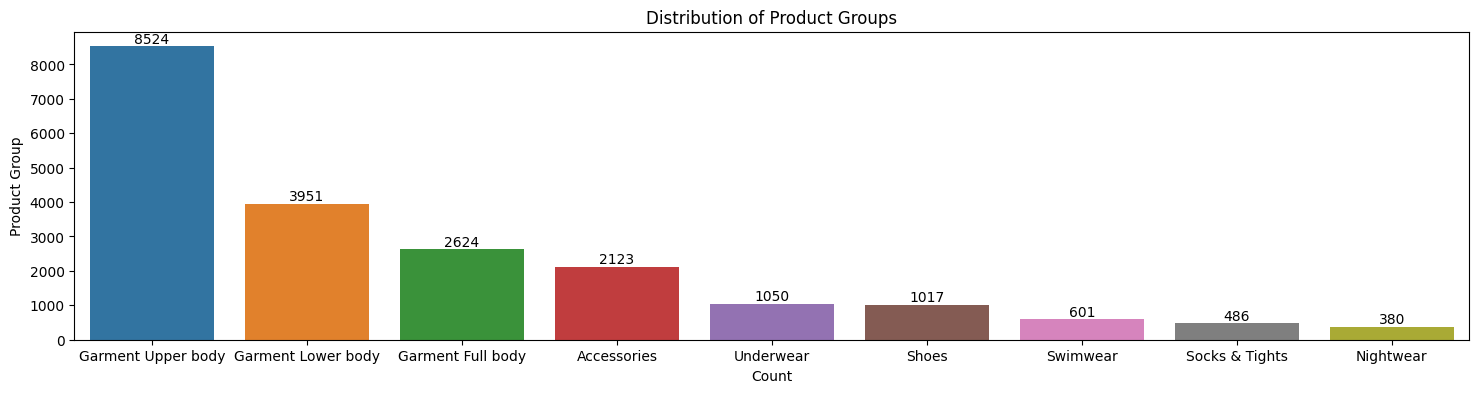

In [130]:
plt.figure(figsize=(18,4))
plot = sns.barplot(data=image_data, x=image_data['product_group_name'].value_counts().index, y=image_data['product_group_name'].value_counts());
plot.bar_label(plot.containers[0])
plt.ylabel('Product Group')
plt.xlabel('Count')
plt.title('Distribution of Product Groups');

Most products in the dataset were upper body garment, lower body garment and full body garment.

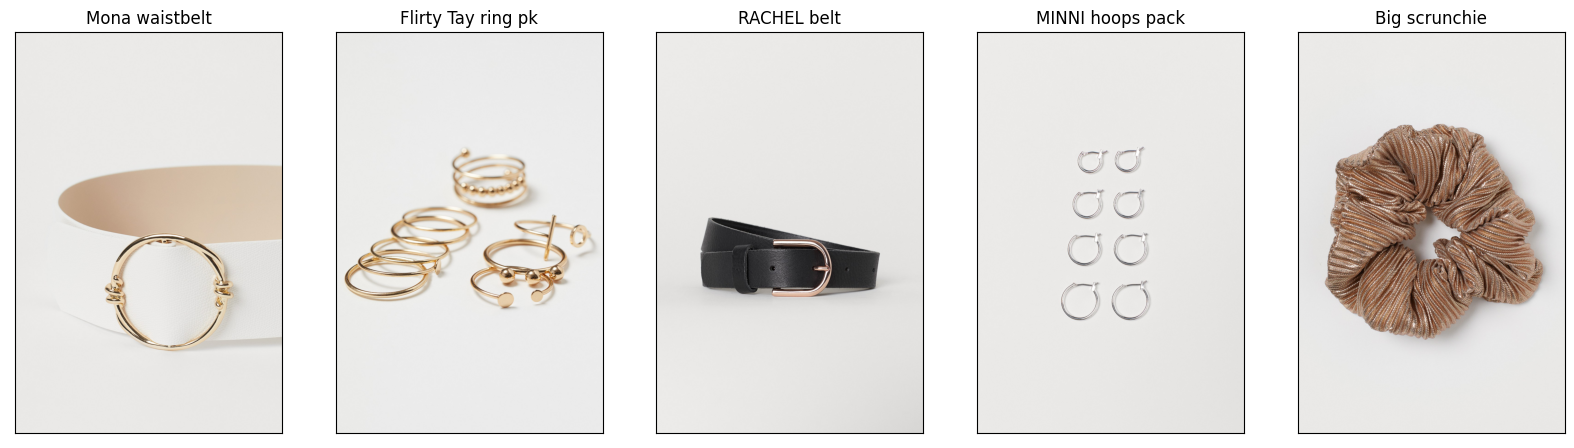

In [131]:
# Show 5 samples of 'Accessories'
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for index, row in image_data[image_data['product_group_name']=='Accessories'].head().iterrows():
    img = mpimg.imread(row['img_path'])
    product_name = row['prod_name']
    ax[i].imshow(img)
    ax[i].set_title(f'{product_name}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    i+=1

plt.show()

The products within each group also varied. For example, the acccessories included a variety of belt, earrings, and hair bands.

#### 2. Product Index

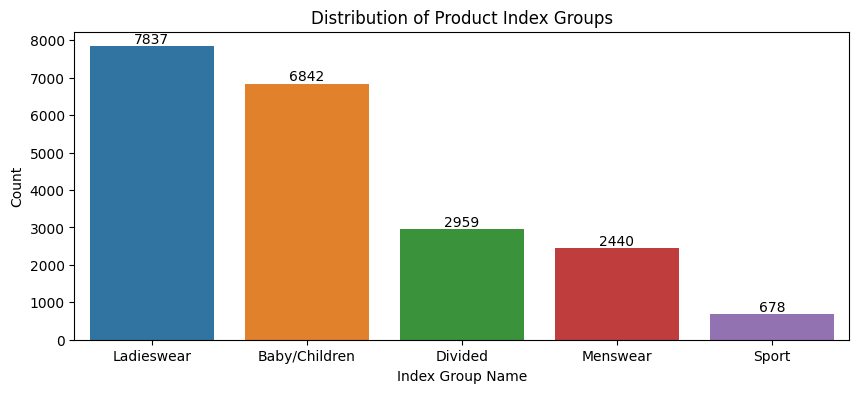

In [176]:
plt.figure(figsize=(10,4))
plot = sns.barplot(data=image_data, x=image_data['index_group_name'].value_counts().index, y=image_data['index_group_name'].value_counts())
plot.bar_label(plot.containers[0])
plt.title('Distribution of Product Index Groups')
plt.xlabel('Index Group Name')
plt.ylabel('Count');

- Ladieswear had the largest selection of products.
- There was a significant portion of 'Divided' products.

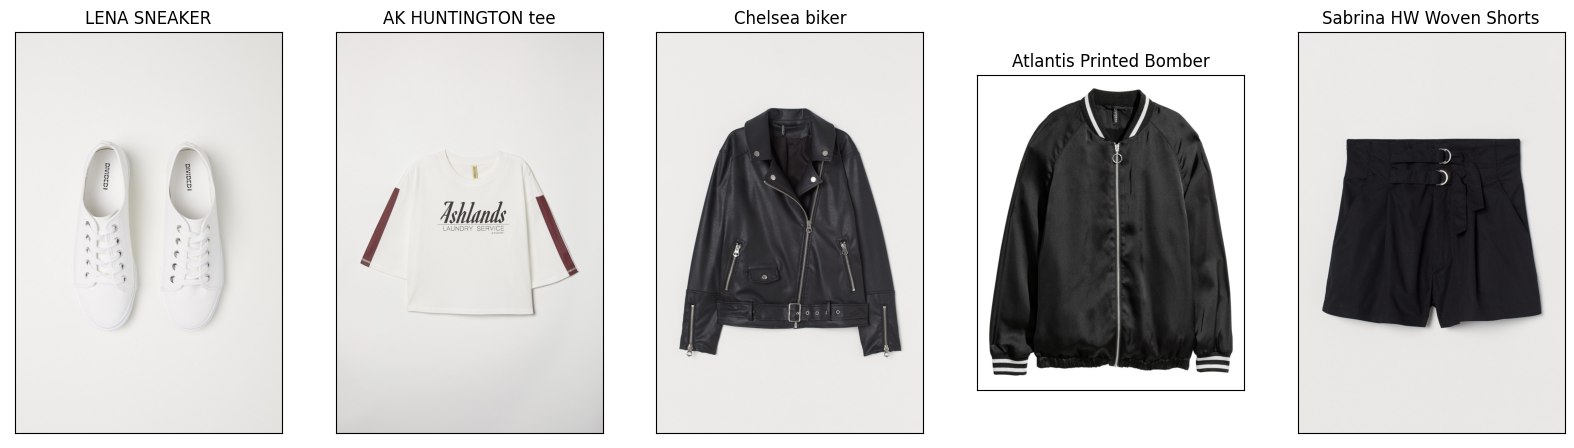

In [137]:
# Show 5 samples of 'Divided'
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for index, row in image_data[image_data['index_group_name']=='Divided'].head().iterrows():
    img = mpimg.imread(row['img_path'])
    product_name = row['prod_name']
    ax[i].imshow(img)
    ax[i].set_title(f'{product_name}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    i+=1

plt.show()

- The 'Divided' could potentially mean gender-neutral items, based on the images.

#### 3. Colour Group

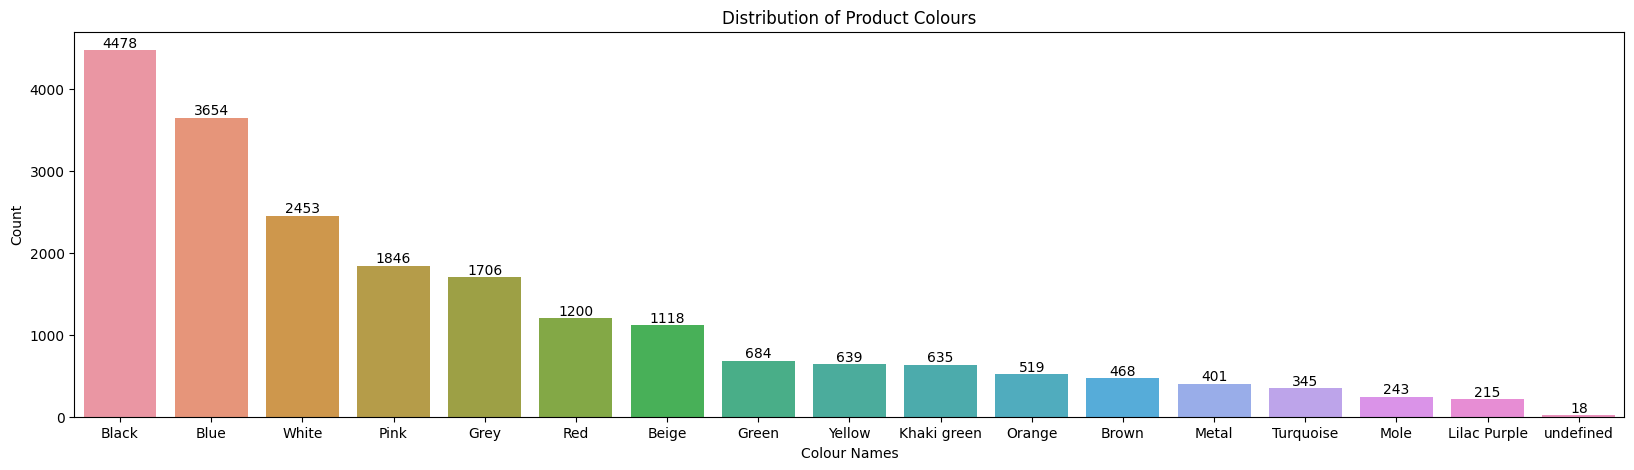

In [177]:
plt.figure(figsize=(20,5))
plot = sns.barplot(data=image_data, x=image_data['perceived_colour_master_name'].value_counts().index, y=image_data['perceived_colour_master_name'].value_counts())
plot.bar_label(plot.containers[0])
plt.title('Distribution of Product Colours')
plt.xlabel('Colour Names')
plt.ylabel('Count');

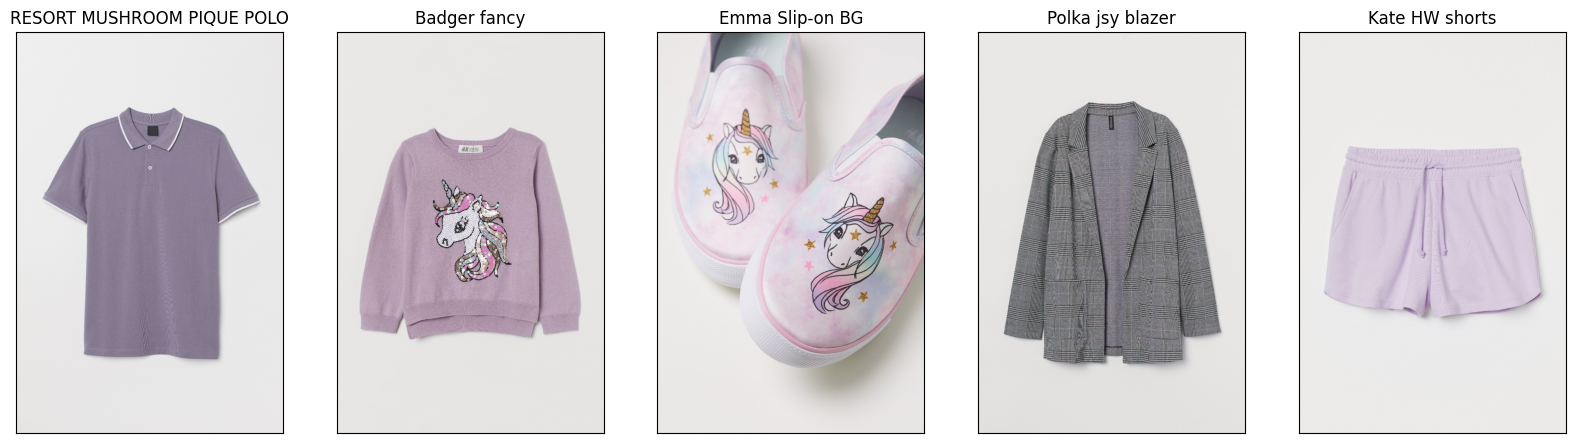

In [140]:
# Show 5 samples of 'Lilac Purple' color
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for index, row in image_data[image_data['perceived_colour_master_name']=='Lilac Purple'].head().iterrows():
    img = mpimg.imread(row['img_path'])
    product_name = row['prod_name']
    ax[i].imshow(img)
    ax[i].set_title(f'{product_name}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    i+=1

plt.show()

#### 4. Graphical Appearance

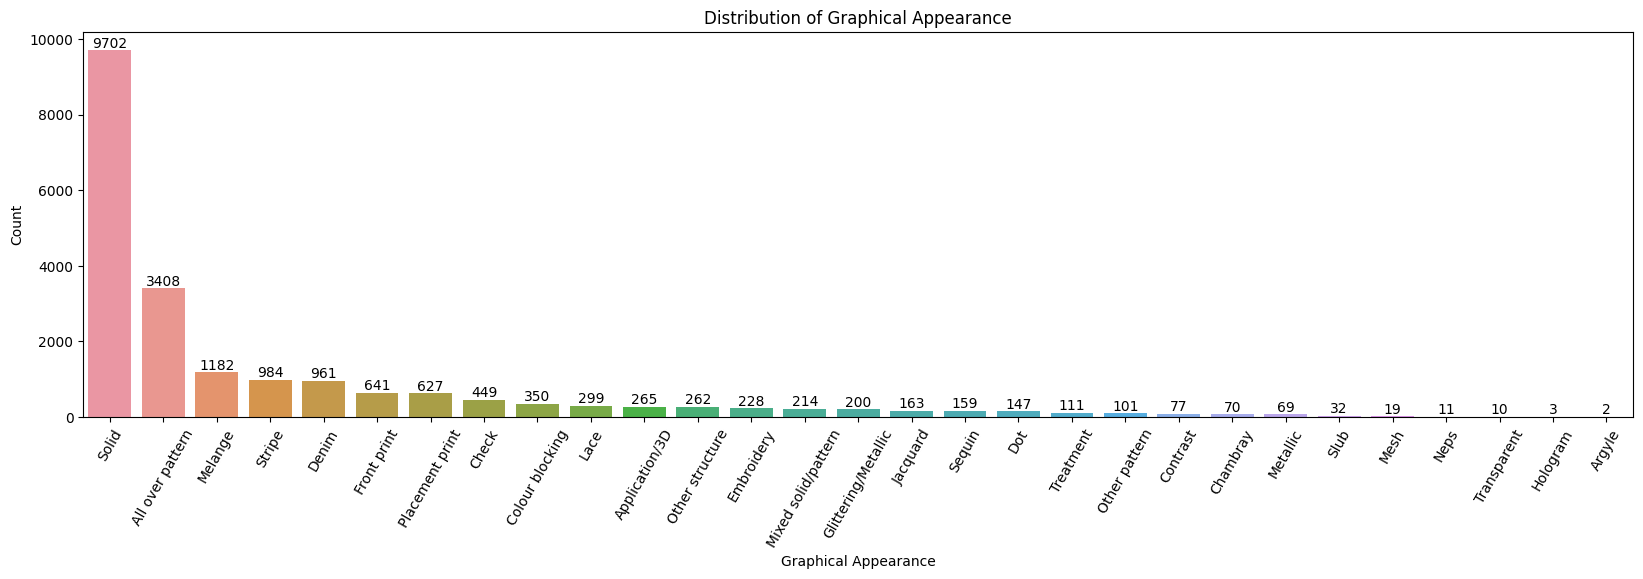

In [181]:
plt.figure(figsize=(20,5))
plot = sns.barplot(data=image_data, x=image_data['graphical_appearance_name'].value_counts().index, y=image_data['graphical_appearance_name'].value_counts())
plot.bar_label(plot.containers[0])
plt.title('Distribution of Graphical Appearance')
plt.xlabel('Graphical Appearance')
plt.ylabel('Count')
plt.xticks(rotation=60);

- Most products are categorised as having 'solid' graphical appearance.
- The 2nd most common graphical pattern is 'All over pattern'.

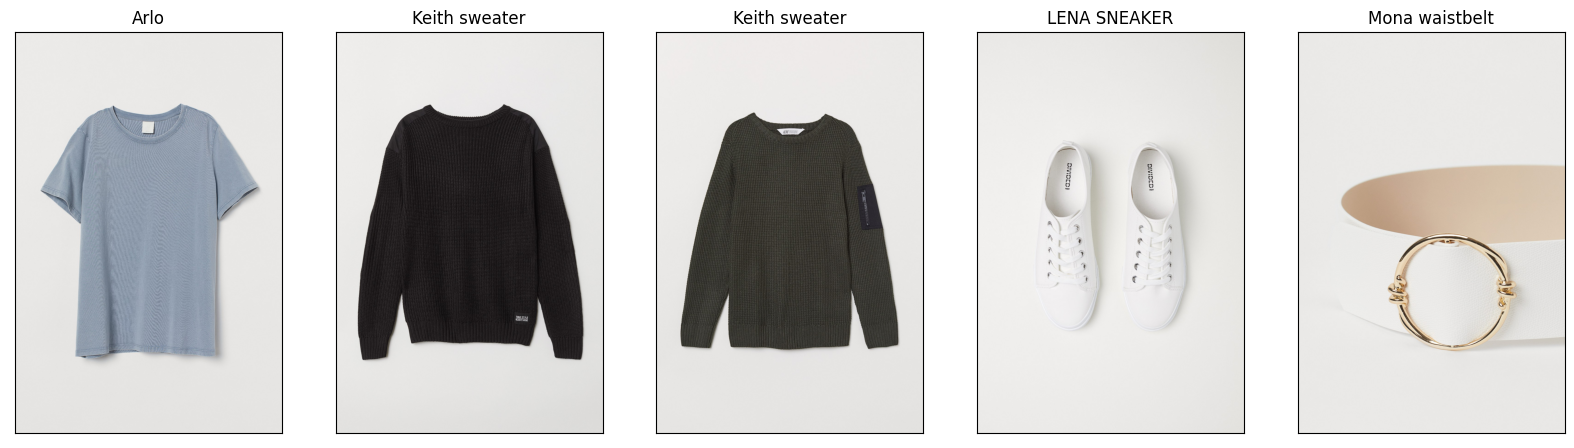

In [182]:
# Show 5 samples of 'solid' products
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for index, row in image_data[image_data['graphical_appearance_name']=='Solid'].head().iterrows():
    img = mpimg.imread(row['img_path'])
    product_name = row['prod_name']
    ax[i].imshow(img)
    ax[i].set_title(f'{product_name}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    i+=1

plt.show()

- 'solid' likely means the product has pure colors with little patterns.

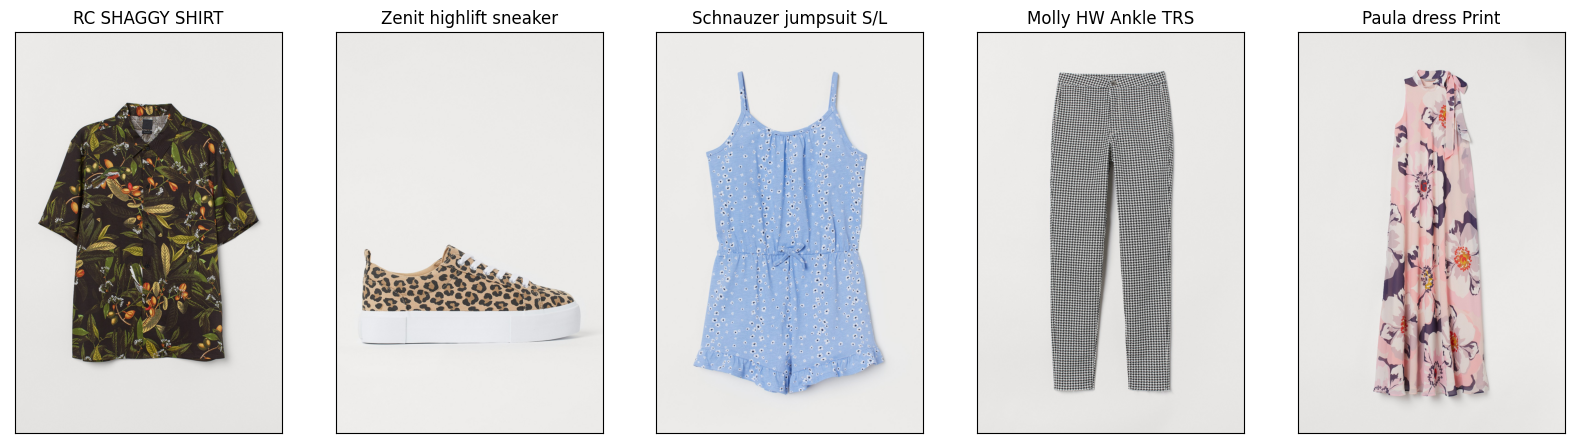

In [184]:
# Show 5 samples of 'All over pattern' products
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for index, row in image_data[image_data['graphical_appearance_name']=='All over pattern'].head().iterrows():
    img = mpimg.imread(row['img_path'])
    product_name = row['prod_name']
    ax[i].imshow(img)
    ax[i].set_title(f'{product_name}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    i+=1

plt.show()

- 'All over pattern' likely means the product is very colorful and has rich graphical patterns.

## Exploratory Data Analysis for Dataset 2: Transactions

**Implicit vs Explicit Customer Data**
<br>
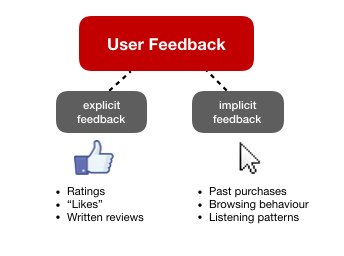

There are two broad categories of customer data as shown in the image.

The current dataset falls under the implicit category, since it's data of past purchases without explicit customer ratings.

In [143]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514121 entries, 0 to 514120
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   t_dat        514121 non-null  object
 1   customer_id  514121 non-null  object
 2   article_id   514121 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.8+ MB


In [144]:
# Check unique values
transactions.nunique()

t_dat            734
customer_id    10700
article_id      4488
dtype: int64

- The transactions data were collected from 10700 customers
- The transactions history included 4488 unique products from H&M

In [145]:
# Check missing values
transactions.isnull().sum()

t_dat          0
customer_id    0
article_id     0
dtype: int64

- There was no missing values in this dataset

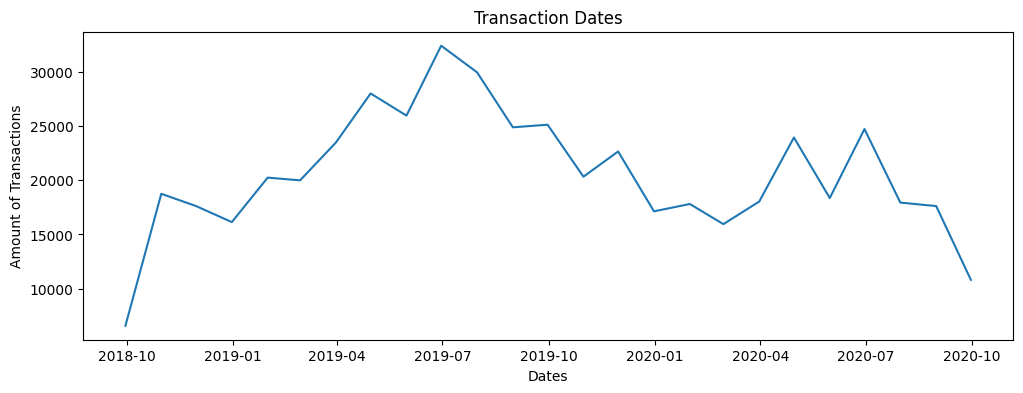

In [150]:
# Plot period of transactions
# Set transaction dates as index
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions.set_index('t_dat',inplace=True)
   
# Time series plot
plt.figure(figsize=(12,4))
plt.plot(transactions.resample('M').size())
plt.ylabel('Amount of Transactions')
plt.xlabel('Dates')
plt.title('Transaction Dates');

- The transaction data was collected across a span of 2 years, between Oct 2018 and Oct 2020.
- Transaction volumns peaked around July 2019.

## Merged Dataset

The image and product data was merged with transaction data to examine patterns in sales.

In [151]:
# Count the number of times each product was purchased using transaction data
articles_count = transactions["article_id"].value_counts().to_frame('count').reset_index(names='article_id')

# Merge the sales data with image and product data
articles_count = pd.merge(articles_count,image_data,on='article_id')
articles_count.sort_values(by='count',ascending=False,inplace=True)
articles_count.head()

,article_id,count,img_path,prod_name,product_group_name,graphical_appearance_name,perceived_colour_master_name,index_group_name,detail_desc
0,706016001,4041,../datasets/images/0706016001.jpg,Jade HW Skinny Denim TRS,Garment Lower body,Solid,Black,Divided,High-waisted jeans in washed superstretch deni...
1,706016002,2331,../datasets/images/0706016002.jpg,Jade HW Skinny Denim TRS,Garment Lower body,Solid,Blue,Divided,High-waisted jeans in washed superstretch deni...
2,706016015,1358,../datasets/images/0706016015.jpg,Jade HW Skinny Denim TRS,Garment Lower body,Solid,Grey,Divided,High-waisted jeans in washed superstretch deni...
3,572797001,1264,../datasets/images/0572797001.jpg,ESSENTIAL TANKTOP LACE TVP,Garment Upper body,Solid,Black,Ladieswear,Fitted vest top in soft cotton jersey with lac...
4,673677002,1250,../datasets/images/0673677002.jpg,Henry polo. (1),Garment Upper body,Solid,Black,Ladieswear,"Jumper in a soft, fine knit with a ribbed polo..."


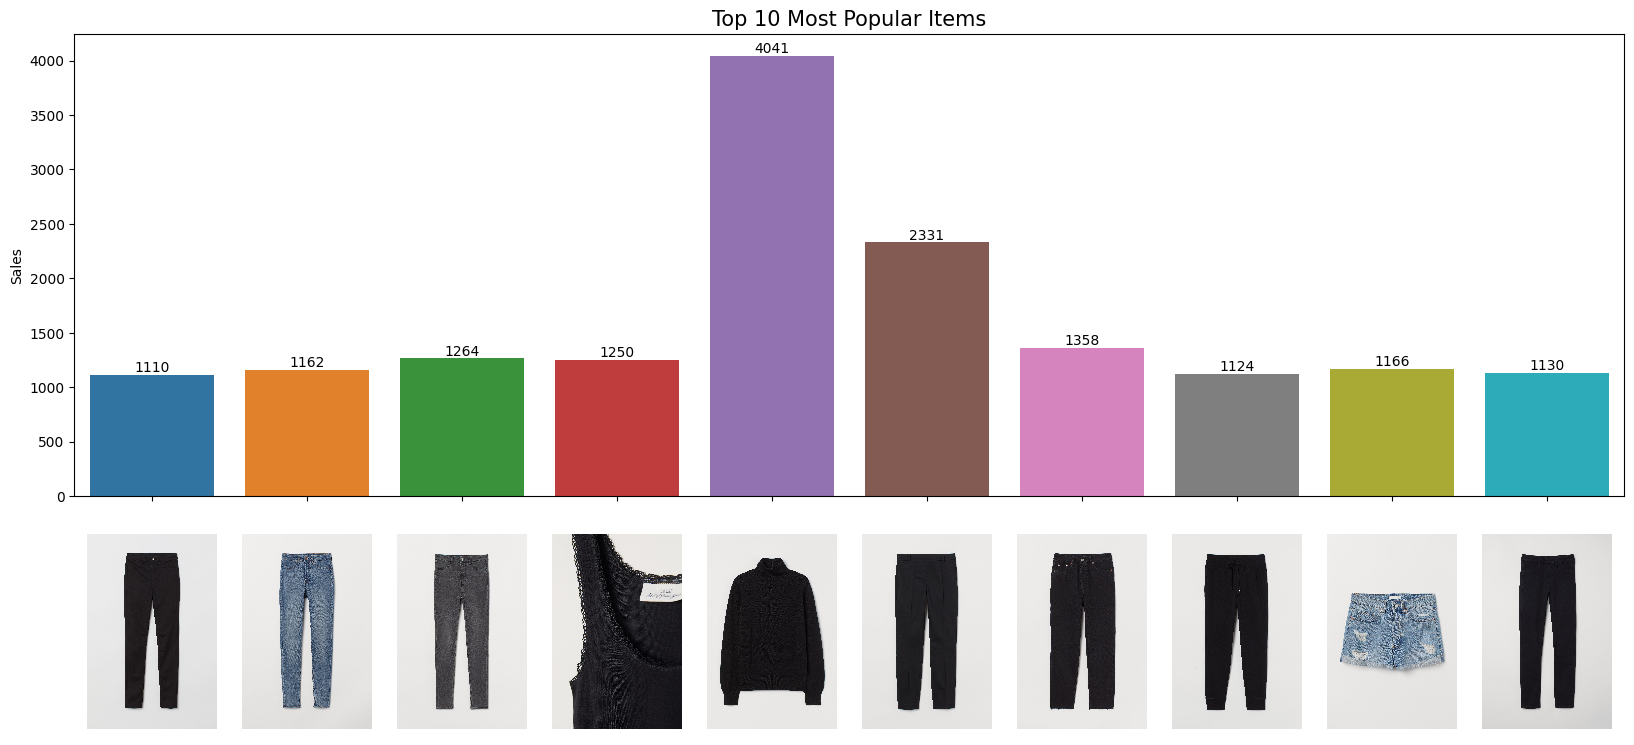

In [152]:
# Top 10 most popular items
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

top_10 = articles_count.head(10)

img = [Image.open(path) for path in top_10['img_path']]

plt.figure(figsize=(20,6))
ax = sns.barplot(data=top_10, x='article_id', y='count');
plt.xticks(list(range(0,10)), list(' '*10))
tick_labels = ax.xaxis.get_ticklabels()

for index,image in enumerate(img):
    ib = OffsetImage(image, zoom=.08)
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
                    tick_labels[index].get_position(),
                    frameon=False,
                    box_alignment=(0.5, 1.2)
                    )
    ax.add_artist(ab)

ax.set(xlabel=None)
ax.set_ylabel('Sales')
ax.bar_label(ax.containers[0])
ax.set_title('Top 10 Most Popular Items',fontsize=15);

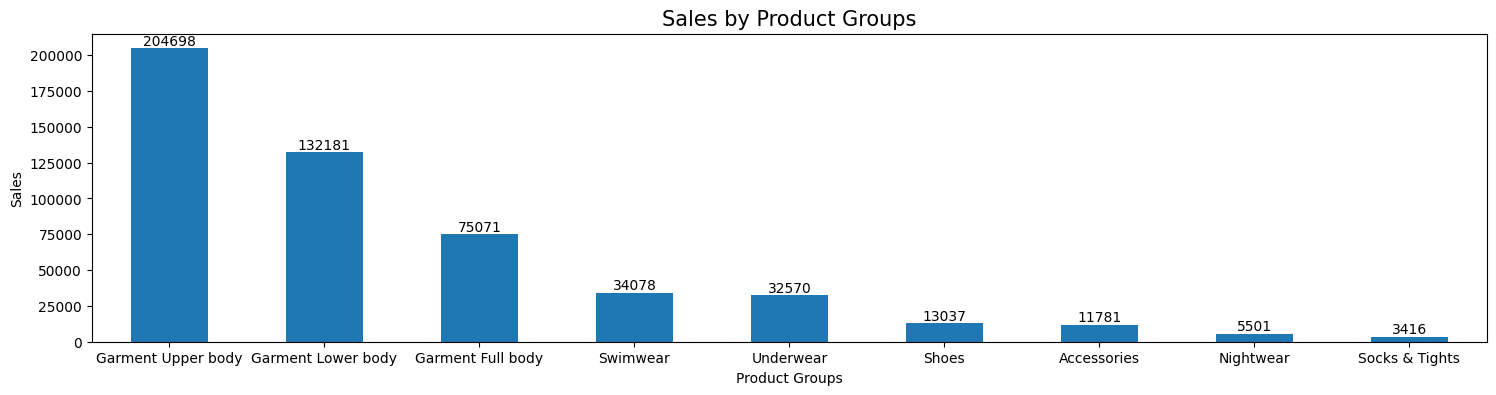

In [166]:
# Sales by product groups
plt.figure(figsize=(18,4))
plot = articles_count.groupby('product_group_name')['count'].sum().sort_values(ascending=False).plot(kind='bar')
plt.bar_label(plot.containers[0])
plt.xticks(rotation=0);
plt.xlabel('Product Groups');
plt.ylabel('Sales')
plt.title('Sales by Product Groups',fontsize=15);

- Most transacted product groups are upperbody garmet, lower body garment and full body garment.

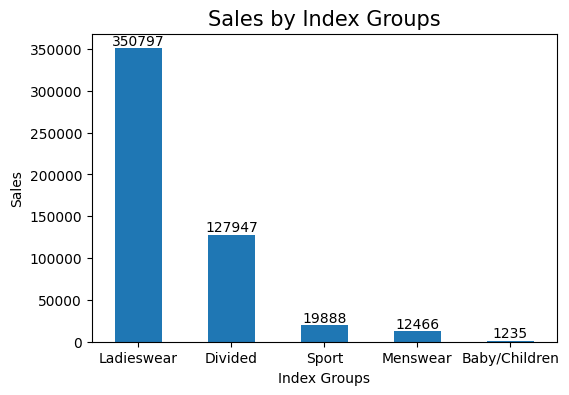

In [159]:
# Sales by product index groups
plt.figure(figsize=(6,4))
plot = articles_count.groupby('index_group_name')['count'].sum().sort_values(ascending=False).plot(kind='bar')
plt.bar_label(plot.containers[0])
plt.xticks(rotation=0);
plt.xlabel('Index Groups');
plt.ylabel('Sales')
plt.title('Sales by Index Groups',fontsize=15);

- Sales mostly came from ladieswear, which had a far larger transaction volumn than the other groups.

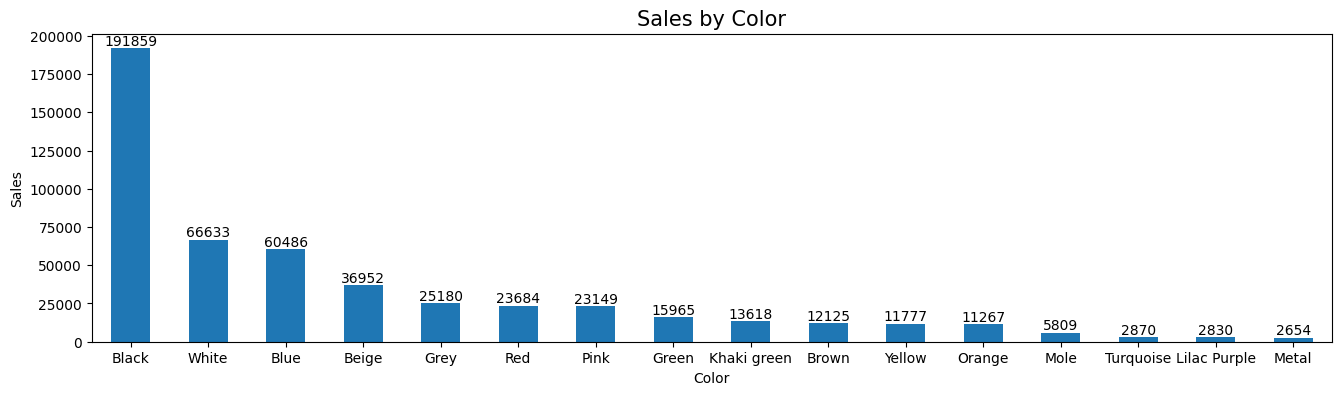

In [163]:
# Sales by color
plt.figure(figsize=(16,4))
plot = articles_count.groupby('perceived_colour_master_name')['count'].sum().sort_values(ascending=False).plot(kind='bar')
plt.bar_label(plot.containers[0])
plt.xticks(rotation=0);
plt.xlabel('Color');
plt.ylabel('Sales')
plt.title('Sales by Color',fontsize=15);

- Most popular products were black in color. This was consistent with the plot of 'Top 10 most popular items'.

## Export Data

Since the recommender would be built using features in the images for more accurate results, the feature columns in the original dataset would be dropped, since these features would be extracted from the images.

In [168]:
# Export the image_data
image_data.to_csv('../datasets/image_data.csv',index=False,columns=['img_path','article_id','detail_desc'])

## Summary of Exploratory Data Analysis

- The image and product dataset contains 20k+ unique products from H&M. The products vary significantly in types, colour and graphical patterns. A content-based recommender can be built by extracting the rich features in the image.
- The transaction data included 500k+ transaction records collected across a span of 2 years, between Oct 2018 and Oct 2020. It is a implicit user dataset and can be used to generate recommendations based on purchase history.